# 実践コンピュータビジョン

[実践 コンピュータビジョン](https://www.oreilly.co.jp/books/9784873116075/)  

演習ノート

# 1. 基本的な画像処理

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path    
import sys
sys.path.append("../")
from impro import impro

## 1.2 Matplotlib
### 1.2.1 画像と点を表示する

In [6]:
# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))

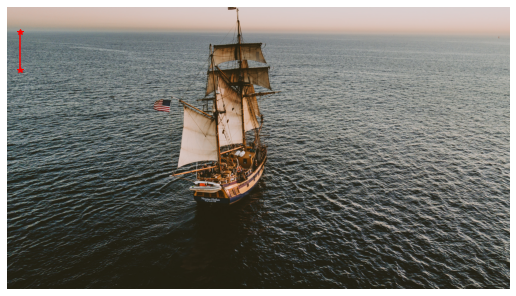

In [7]:
impro.imshow(im,isBGR=True)
plt.plot([100,100],[200,500],"-r*")

### 1.2.2 画像の等高線とヒストグラム

In [10]:
# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

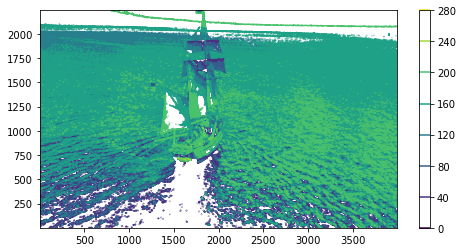

In [20]:
# 等高線を表示する
plt.figure(figsize=(8,4))
plt.contour(im_gray,origin="image")
plt.colorbar()

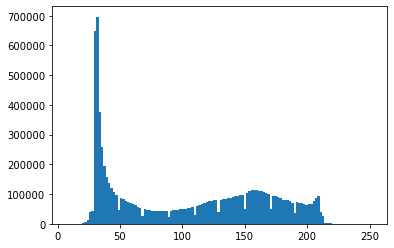

In [23]:
# ヒストグラムを表示する
ax=plt.hist(im_gray.flatten(),128)

# 1.2.3 インタラクティブな注釈
実行環境がコンテナ上のJupyterなので、教科書そのままのコードでは実行できない。  
`%matplotlib notebook`する必要があると思われる

## 1.3 Numpy
### 1.3.1 配列による画像表現
`cv2`で読みこんでいるのですでに`np.array`になっている。


In [12]:
# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))
print("タイプ: ",type(im))
print("タイプ: ",im.shape)

タイプ:  <class 'numpy.ndarray'>
タイプ:  (2242, 3992, 3)


### 1.3.2 グレーレベルへの変換

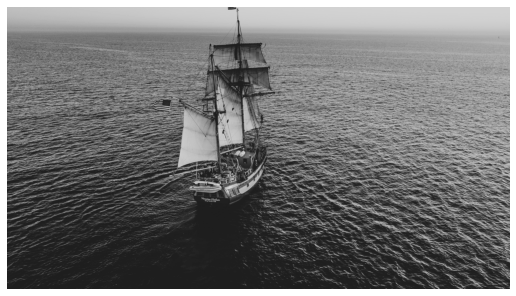

In [18]:
# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
impro.imshow(im_gray)

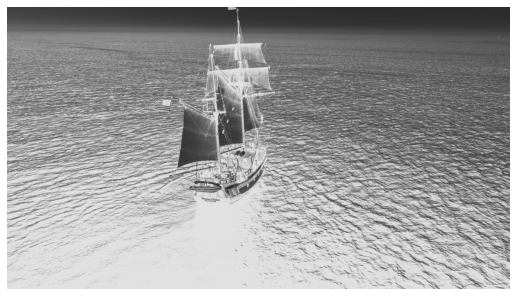

In [14]:
# 画像を反転する
im_reverce=255-im_gray
impro.imshow(im_reverce)

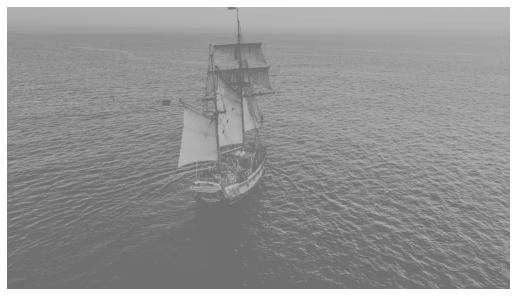

In [15]:
# 100から200の間の値に収める
im_limit = im_gray* (100/255)+100
impro.imshow(im_limit)

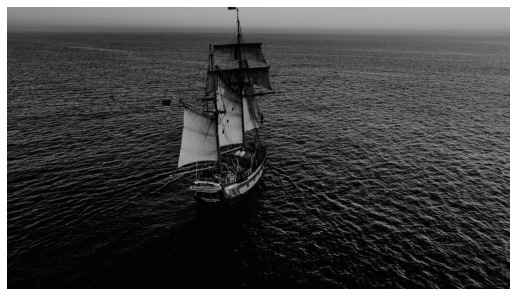

In [17]:
# 2乗する
im_square=(im_gray/255) **2 * 255
impro.imshow(im_square)

### 1.3.3 画像のサイズ変更
アフィン変換を使って`impro.scale`に実装してある。

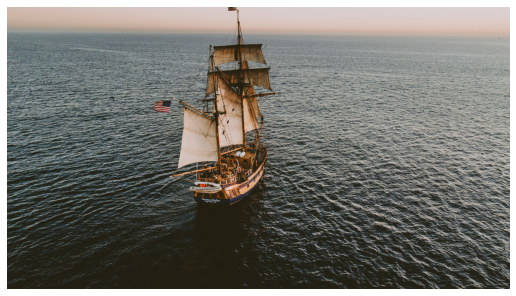

In [2]:
# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))
im_scaled=impro.scale(im,ratio=0.4)
impro.imshow(im_scaled)

### 1.3.4 ヒストグラム平坦化

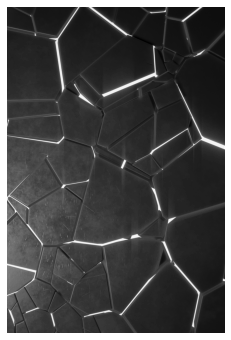

In [28]:
# 画像を読み込む(出現頻度に偏りがある画像のほうがいいので別の画像を読み込む)
im_path=Path("resources/sample_images/risto-kokkone.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
impro.imshow(im_gray)

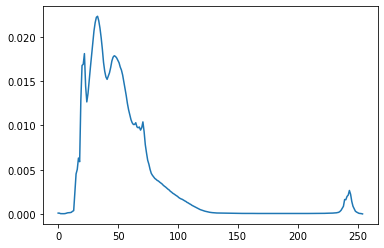

In [29]:
# 出現頻度(ヒストグラム)を計算し、プロットする
imhist,bins=np.histogram(im_gray.flatten(),bins=256,density=True)
plt.plot(bins[:-1],imhist)

In [39]:
type(bins)

numpy.ndarray

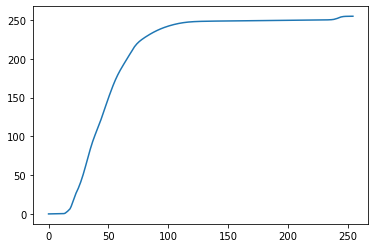

In [30]:
# 出現頻度を累積和する
cdf=imhist.cumsum()
cdf=255*cdf/cdf[-1]

plt.plot(bins[:-1],cdf)

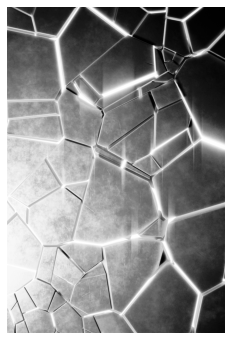

In [31]:
# np.interp(x,xp,fp)でxの点を(xp、fp)という組み合わせの関数で補間する
# (つまりy=f(x)という関数があったとして、xpの点の値fpしかわかっていない状況)

# 今回im_grayで出現する明るさの点を、cdfに基づいて補間する
# そうすると出現回数が多い明るさはばらける

# ある明るさの付近が出現回数が多い
# →その付近はヒストグラムで高い山となる
# →ヒストグラムを累積和したcdfの傾きが急
# →補間されるときに明るさがばらけやすい
im_flatten=np.interp(im_gray.flatten(),bins[:-1],cdf)
im_flatten=im_flatten.reshape(im_gray.shape)
impro.imshow(im_flatten)

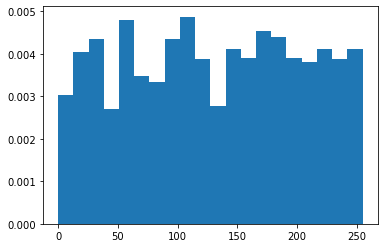

In [38]:
# ヒストグラム平坦化した画像のヒストグラムを再度見る
# binの数が20程度だと、ヒストグラムが平坦化しているのが分かる
# (binの数を増やしすぎると補間の粗が出てくる)
ax=plt.hist(im_flatten.flatten(),density=True,bins=20)

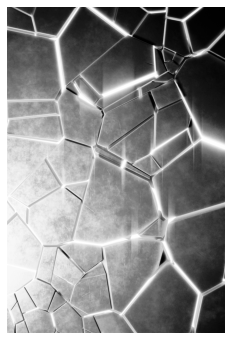

In [3]:
# 自作モジュールに実装したhisteqを使ってみる
im_path=Path("resources/sample_images/risto-kokkone.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im_eq,cdf=impro.histeq(im_gray)
impro.imshow(im_eq)

### 1.3.5 平均画像
以下は今やりたいことに関係なさそうなのでスキップ
- 1.3.5 平均画像
- 1.3.6 画像の主成分分析
- 1.3.7 pickleモジュール


## 1.4 Scipy
### 1.4.1 画像をぼかす

#### 畳み込み

$$
I_\sigma=I*G_\sigma
$$

これは
$$
I_\sigma=\int_y\int_x I(x',y')G_\sigma(x-x',y-y')dx'dy'
$$
というここと  
参考:[合成積（畳み込み）の意味と応用３つ | 高校数学の美しい物語](https://manabitimes.jp/math/954)

イメージとしては画素のある一点を中心に、周辺の画素とガウス分布を掛け合わせて足しあげたものをその画素の明るさとするということ。

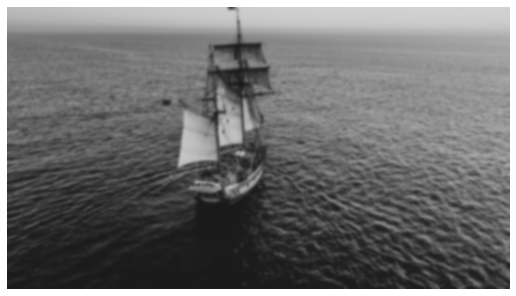

In [74]:
from scipy import ndimage

# 画像を読み込む
im_path=Path("resources/sample_images/austin-neill.jpg")
im=cv2.imread(str(im_path))
im_filtered=ndimage.gaussian_filter(im,10)
impro.imshow(im_filtered)
# ※チャネル方向も平滑化されるので、白黒になってしまう。

# 1.4.2 画像の微分

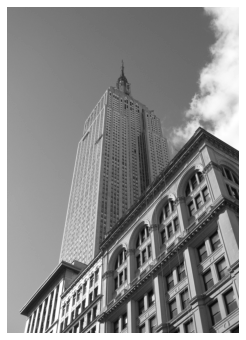

In [82]:
# 輪郭がはっきりしている画像のほうがいいので別の画像を使う
im_path=Path("resources/sample_images/empire.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
impro.imshow(im_gray)

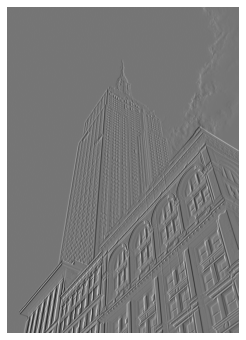

In [80]:
# sobelはそのまま使うとim_grayと同じdtype、つまりuint8で画像を生成してしまい、
# マイナスや255を上回った場合、アンダーフロー、オーバーフローしてしまう。
# なのでdtypeでfloatと指定することで、それを防ぐ。
imx=ndimage.sobel(im_gray,1,float)

impro.imshow(imx,show_mode="scale")

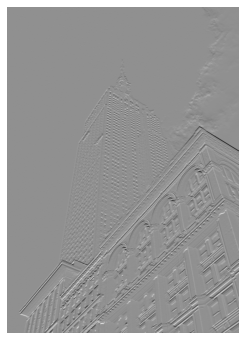

In [81]:
imy=ndimage.sobel(im_gray,0,float)

# imx、imyにはマイナス、255をオーバーした値も含まれるので
# 最小値が0、最大値が255になるようスケールして表示する
impro.imshow(imy,show_mode="scale")

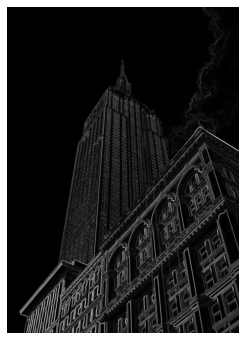

In [83]:
magnitude = np.sqrt(imx**2 + imy**2)
impro.imshow(magnitude,show_mode="scale")

**ガウシアン微分フィルタ**

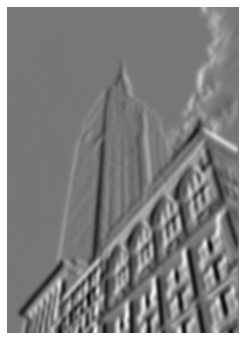

In [87]:
sigma=5
imx_g=ndimage.gaussian_filter(im_gray,(sigma,sigma),(0,1),float)
impro.imshow(imx_g,show_mode="scale")

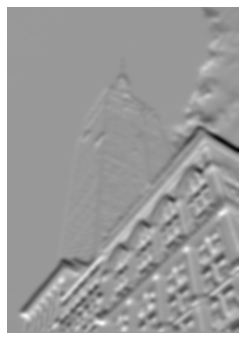

In [91]:
imy_g=ndimage.gaussian_filter(im_gray,(sigma,sigma),(1,0),float)
impro.imshow(imy_g,show_mode="scale")

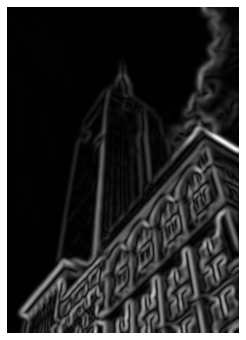

In [92]:
magnitude = np.sqrt(imx_g**2 + imy_g**2)
impro.imshow(magnitude,show_mode="scale")

### 1.4.3 モルフォロジー - 物体を数える
以下はやりたいことと関係なさそうなのでスキップ  
- 1.4.3 モルフォロジー - 物体を数える
- 1.4.4 便利なscipyモジュール
- 1.5 高度な例: 画像のノイズ除去